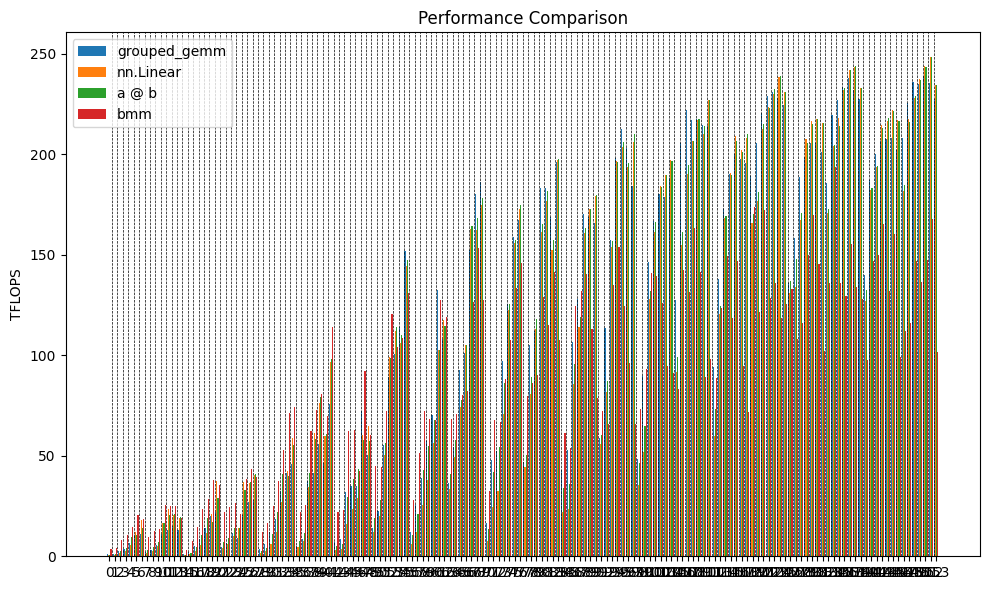

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Read the data file
with open('perf.txt', 'r') as file:
    data = file.read()
parts = data.split('-' * 50)

batch_sizes = []
sequence_lengths = []
hidden_sizes = []
ffn_dims = []
grouped_gemm_tflops = []
nn_linear_tflops = []
a_b_tflops = []
bmm_tflops = []

# Traverse each part and extract the relevant information
for part in parts:
    lines = part.strip().split('\n')
    if len(lines) < 10:
        continue
    
    params = lines[0].split(':')[1].split(',')
    batch_size = int(params[0].split('=')[1])
    sequence_length = int(params[1].split('=')[1])
    hidden_size = int(params[2].split('=')[1])
    ffn_dim = int(params[3].split('=')[1])
    
    batch_sizes.append(batch_size)
    sequence_lengths.append(sequence_length)
    hidden_sizes.append(hidden_size)
    ffn_dims.append(ffn_dim)
    
    for line in lines:
        if 'TFLOPS (grouped_gemm):' in line:
            grouped_gemm_tflops.append(float(line.split(':')[1]))
        elif 'TFLOPS (nn.Linear):' in line:
            nn_linear_tflops.append(float(line.split(':')[1]))
        elif 'TFLOPS (a @ b):' in line:
            a_b_tflops.append(float(line.split(':')[1]))
        elif 'TFLOPS (bmm):' in line:
            bmm_tflops.append(float(line.split(':')[1]))


# Create a bar chart
x = np.arange(len(batch_sizes))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, grouped_gemm_tflops, width, label='grouped_gemm')
rects2 = ax.bar(x - 0.5*width, nn_linear_tflops, width, label='nn.Linear')
rects3 = ax.bar(x + 0.5*width, a_b_tflops, width, label='a @ b')
rects4 = ax.bar(x + 1.5*width, bmm_tflops, width, label='bmm')

# Add vertical dashed lines between each group of bar charts
for i in range(1, len(x)):
    ax.axvline(i - 0.5, color='k', linestyle='--', linewidth=0.5)

ax.set_ylabel('TFLOPS')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels([f'bs={bs}, sl={sl}, hs={hs}, fd={fd}' for bs, sl, hs, fd in zip(batch_sizes, sequence_lengths, hidden_sizes, ffn_dims)], rotation=45, ha='right')
ax.legend()

fig.tight_layout()

plt.show()